cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader, plot_histories, plot_history
from functions_cae import train_cae, validate_cae, DeepCAE, SimpleCAE, SimpleCAE_Dropout, visualize_latent_space, visualize_reconstruction, get_latent_dataset
import torch.nn as nn
from functions_mlp import rawMLP, train_mlp, validate_mlp, caeMLP
import matplotlib.pyplot as plt

In [4]:
##### CONFIG
NUM_EPOCHS = 5
LR_RATE = 1e-3
BATCH_SIZE = 4
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

# val_objects = ['12_containerNuts', '13_cornCob', '14_yellowFruitToy',
#             '15_bottleNailPolisher']

# test_objects =['16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

CUDA is available. Using GPU...


In [5]:
train_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

Epoch [1/5], Loss: 0.6182
Average PSNR Epoch [1/5]: 26.1943
Average SSIM Epoch [1/5]: 0.8166


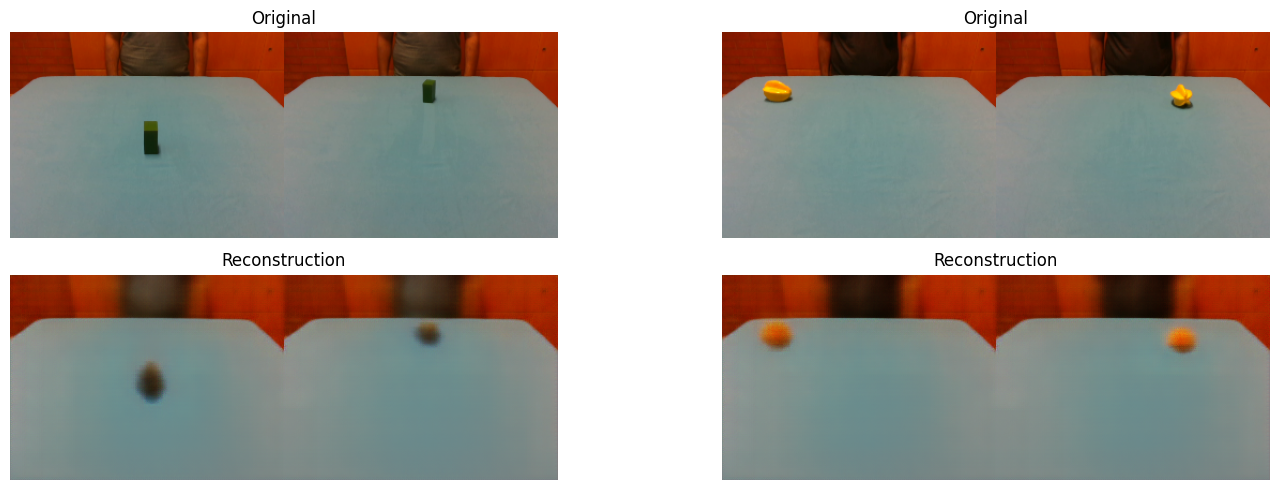

Epoch [2/5], Loss: 0.6110
Average PSNR Epoch [2/5]: 30.3479
Average SSIM Epoch [2/5]: 0.9405


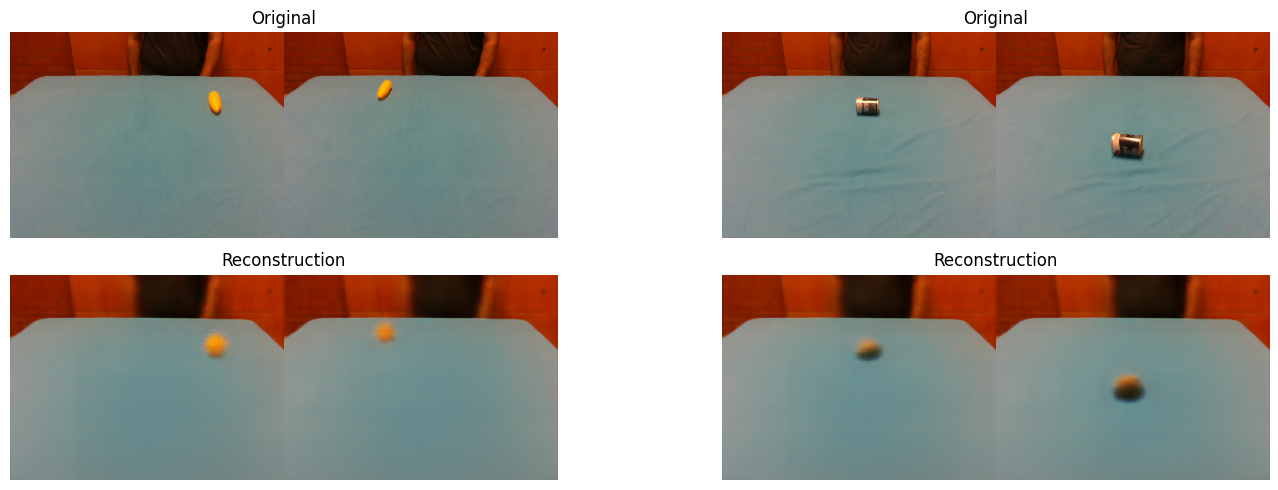

Epoch [3/5], Loss: 0.6104
Average PSNR Epoch [3/5]: 31.4328
Average SSIM Epoch [3/5]: 0.9525


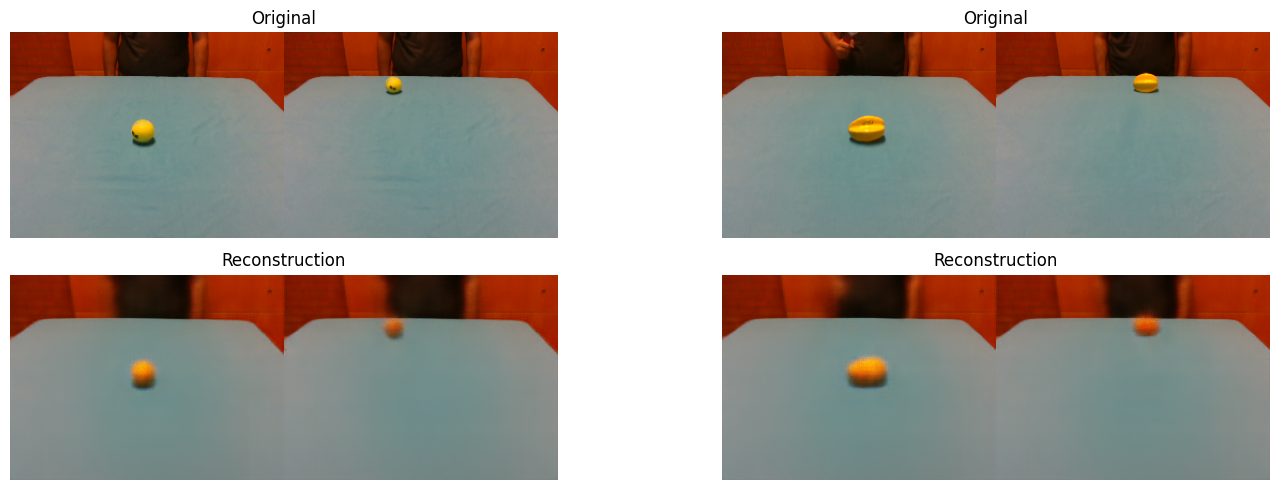

Epoch [4/5], Loss: 0.6101
Average PSNR Epoch [4/5]: 32.1514
Average SSIM Epoch [4/5]: 0.9606


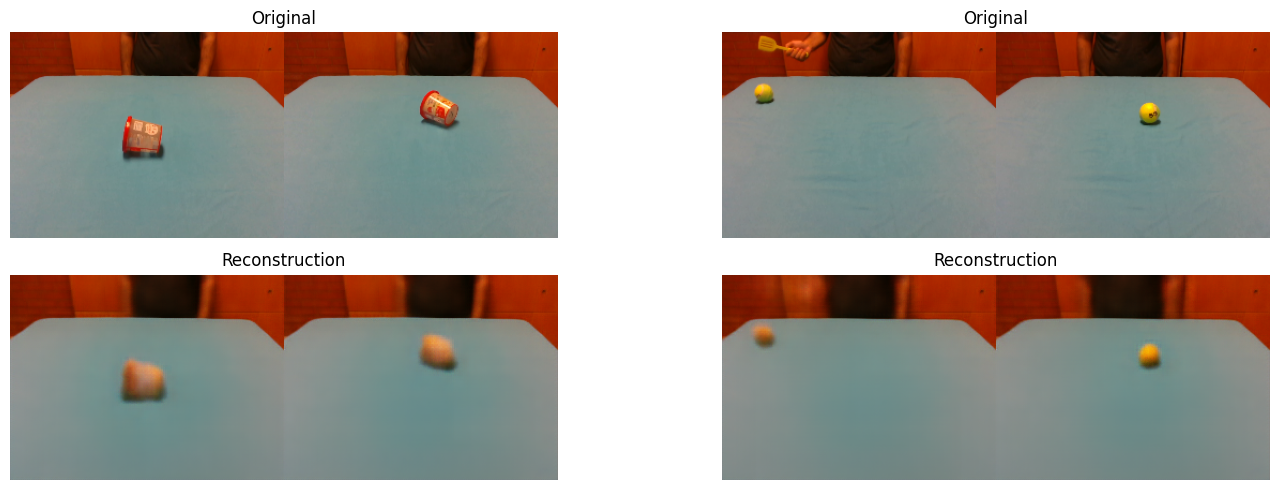

Epoch [5/5], Loss: 0.6098
Average PSNR Epoch [5/5]: 32.8322
Average SSIM Epoch [5/5]: 0.9678


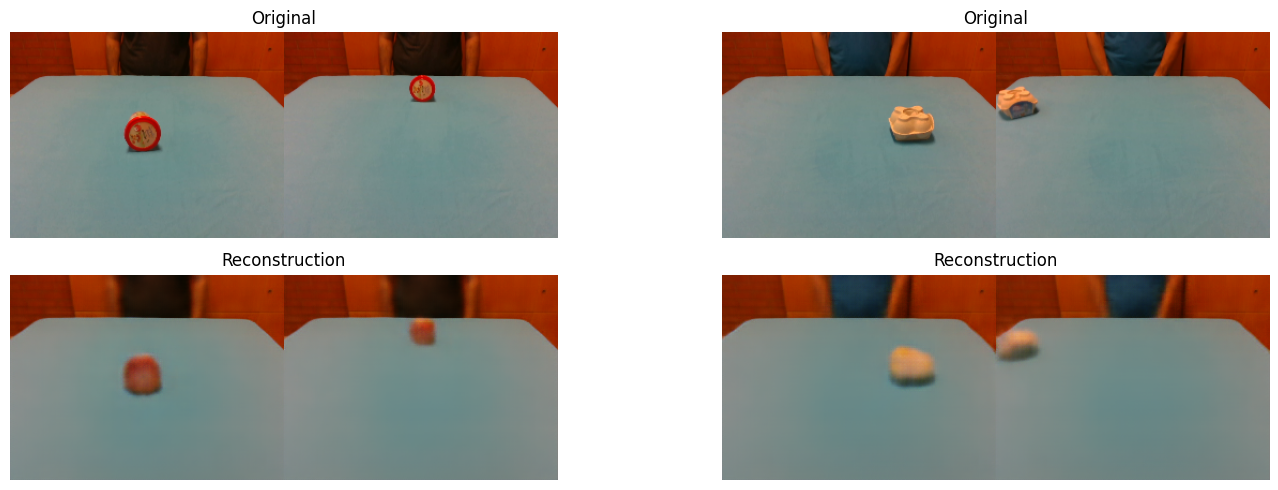

Average Validation Loss: 0.6099236447364091
Average PSNR: 32.293690256209814
Average SSIM: 0.9692220699430744


In [6]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

# Training loop
#cae = SimpleCAE().to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
cae = DeepCAE().to(DEVICE)
cae_optimizer_adam = torch.optim.Adam(cae.parameters(), lr=LR_RATE)
cae_optimizer_sgd = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
cae_optimizer_adamw = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_batch_loss_history, cae_epoch_loss_history = train_cae(cae, train_loader, cae_lossfunction, cae_optimizer_adam, NUM_EPOCHS, True, DEVICE)
avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, test_loader, cae_lossfunction, DEVICE)

In [7]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne5_b4.pth"
torch.save(trained_cae.state_dict(), model_path)

In [5]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne5_b4.pth"
trained_cae = DeepCAE()
trained_cae.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [8]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 5
LR_RATE = 1e-3

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, val_loader)
val_dataset = get_latent_dataset(trained_cae, test_loader)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = caeMLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
validate_mlp(mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/5], Train Loss: 2.4493, Train Acc: 0.3891, Train Precision: 0.3890, Train Recall: 0.3891, Train F1: 0.3890
Epoch [2/5], Train Loss: 0.8846, Train Acc: 0.6734, Train Precision: 0.6741, Train Recall: 0.6734, Train F1: 0.6736
Epoch [3/5], Train Loss: 0.6723, Train Acc: 0.7234, Train Precision: 0.7231, Train Recall: 0.7234, Train F1: 0.7230
Epoch [4/5], Train Loss: 0.4799, Train Acc: 0.8172, Train Precision: 0.8173, Train Recall: 0.8172, Train F1: 0.8171
Epoch [5/5], Train Loss: 0.4025, Train Acc: 0.8484, Train Precision: 0.8494, Train Recall: 0.8484, Train F1: 0.8483
Val Loss: 0.0426, Val Acc: 0.9547, Val Precision: 0.9572, Val Recall: 0.9547, Val F1: 0.9548
Confusion Matrix:
 [[150   0   9   1]
 [  2 146   7   5]
 [  1   0 158   1]
 [  0   1   2 157]]


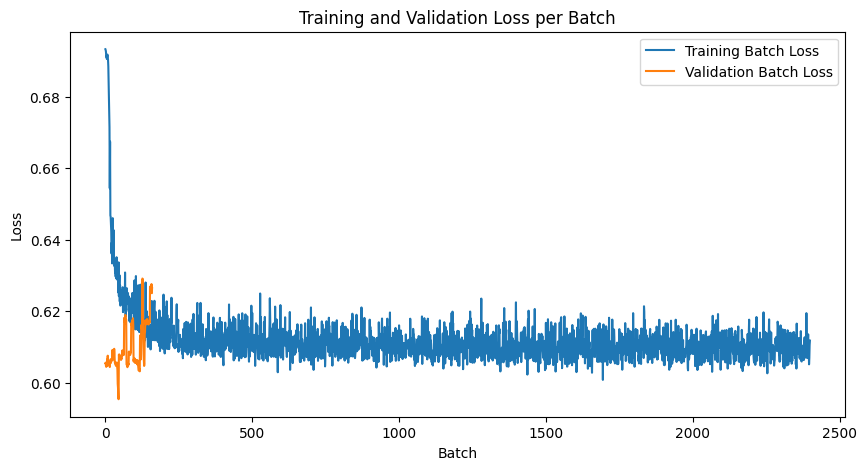

IndexError: index 4 is out of bounds for axis 0 with size 4

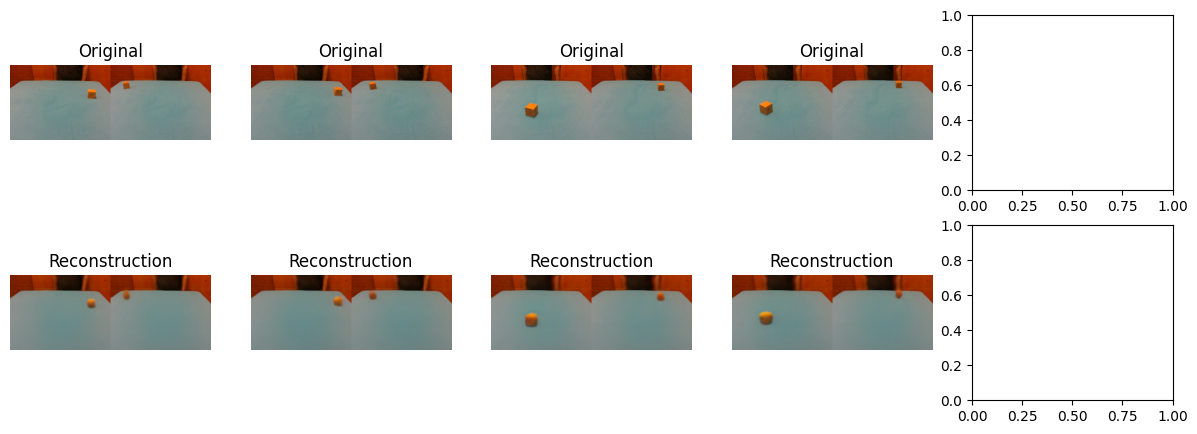

In [9]:
plot_histories(cae_batch_loss_history, cae_validation_loss_history)
visualize_reconstruction(trained_cae, test_loader, num_samples=5)
visualize_latent_space(trained_cae, test_loader, n_components=3)
# plot_history(mlp_epoch_avg_losses)
# plot_history(mlp_epoch_accuracy)

In [ ]:
"early_stopping" after some epochs no improvements.
"superimpose"